## Data Exploration

Use tinyshakespeare dataset

In [ ]:
# download tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-03-04 06:00:01--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.08s   

2024-03-04 06:00:01 (13.8 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [ ]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



## Tokenization (Simple)

OpenAI https://github.com/openai/tiktoken
- bytepair encoding tokenizer (used by GPT2)

Google https://github.com/google/sentencepiece
- not character level, not word level, but sub-word level tokenization

Tradeoff of tokenization
- word -> long vectors (long sequence of integers) with small vocabulary
- word -> short vectors (short sequence of integers) with large vocabulary

This repo uses a very simple tokenization method with long vectors

In [ ]:
# here are all the unique characters that occur in this text
vocab = sorted(list(set(text)))
vocab_size = len(vocab)
print(''.join(vocab))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [ ]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(vocab) }
itos = { i:ch for i,ch in enumerate(vocab) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [ ]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will look like this to the GPT

# based on our vocab:
# 0 is new line character
# 1 is !

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

## Training/Validation Split

In [ ]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

## Context Length

When training GPT, we don't want to feed the entire shakespeare text to the transformer all at once, because that would be too computationally expensive. Hence, we only work with chunks of the dataset and train chunks at a time => context_length

In [ ]:
context_length = 8
train_data[:context_length+1]

# tensor([18, 47, 56, 57, 58,  1, 15, 47, 58]) actually has 8 examples packed in it
# we need offset of +1 because we need the 8th example to have a next char target


tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [ ]:
x = train_data[:context_length]
y = train_data[1:context_length+1]
for t in range(context_length):
    context = x[:t+1]
    target = y[t]
    print(f"example {t+1}) when input is {context} the target: {target}")

# Training the transformer this way also means the transformer will know how to predict next char when there is 1-8 chars in context length

example 1) when input is tensor([18]) the target: 47
example 2) when input is tensor([18, 47]) the target: 56
example 3) when input is tensor([18, 47, 56]) the target: 57
example 4) when input is tensor([18, 47, 56, 57]) the target: 58
example 5) when input is tensor([18, 47, 56, 57, 58]) the target: 1
example 6) when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
example 7) when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
example 8) when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


## Batch Dimension

Everytime we feed chunks of text into the transofmer, we also have minibatches with multiple chunks of text that are stacked up in a single tensor. This is for efficient training purposes, because GPUs are great at parallel processing. The chunks in different batches do not interact with each other and are trained completely independently

In [ ]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
context_length = 8 # what is the maximum context length for predictions?
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_length, (batch_size,)) # randomly generate 4 offset numbers between 0 and len(data) - 8
    x = torch.stack([data[i:i+context_length] for i in ix]) # from random offset as starting point, take context length chunks and stack 4x8 tensors
    y = torch.stack([data[i+1:i+context_length+1] for i in ix]) # target values / prediction values
    x, y = x.to(device), y.to(device)
    return x, y

# input xb and label yb
xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(context_length): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

In [ ]:
print(xb) # our input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


## Bigram Language Model (Simplest Baseline)

Bigram = two chars

Given an input char/token, predict next char/token
Find the current input token from embedding, pluck out the row of the found token, arrange them in (B,T,C), and interpret it as logits (score for char next in sequence)


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        # embedding is size vocab_size x vocab_size
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        # logits has shape (B,T,C) = (batch, time, channel) = (4, 8, vocab_size)
        # logits is a prediction score that a model generates (in this case, model should assign high logits to chars/tokens that are likely next)
        logits = self.token_embedding_table(idx)

        if targets is None:
            # if targets is not provided, we are in inference mode
            loss = None
        else:
            # logits is shape (B,T,C) but pytorch cross_entropy takes in (B,C,T)
            B, T, C = logits.shape
            logits = logits.view(B*T, C) # just make logits 2 dimensional
            targets = targets.view(B*T) # just make targets 2 dimensional
            loss = F.cross_entropy(logits, targets) # are the logits/scores high for the targets?
            # cross entropy calculates the negative log likelihood loss
            # which is basically log(avg difference between two probabilities which values are between 0 and 1) => think log as just a monotonic scale of this probability difference
            # and since loss has a semantic of smaller the better, we take the negative log (not log plot has shape r and log of values between 0 and 1 is negative)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step (i.e the next predicted char)
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution of probabilities and get just 1 sample
            # multinomial just means multiple possible outcomes (binomal means 2 possible outcomes)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
m = m.to(device)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

idx = torch.zeros((1, 1), dtype=torch.long) # (B,T) = (1,1) tensor holding a zero (remember that idx 0 is a new line character)
max_new_tokens = 100 # ask for 100 new tokens
print(decode(m.generate(idx, max_new_tokens)[0].tolist())) # [0] to get the first batch, which means we now have just time steps, and we convert this into a python list

# resulting token predictions are garbage because we didn't train the model

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


## Training the model

In [ ]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [ ]:
batch_size = 32
for steps in range(10000): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    # zero out gradients from previous step (to not use old gradients)
    optimizer.zero_grad(set_to_none=True)
    # backpropagation
    loss.backward()
    # optimizer takes in gradient and updates weight
    optimizer.step()

print(loss.item())


2.5727508068084717


In [ ]:
idx = torch.zeros((1, 1), dtype=torch.long, device=device)
max_new_tokens = 500
print(decode(m.generate(idx, max_new_tokens)[0].tolist()))


Iyoteng h hasbe pave pirance
Rie hicomyonthar's
Plinseard ith henoure wounonthioneir thondy, y heltieiengerofo'dsssit ey
KIN d pe wither vouprrouthercc.
hathe; d!
My hind tt hinig t ouchos tes; st yo hind wotte grotonear 'so it t jod weancotha:
h hay.JUCle n prids, r loncave w hollular s O:
HIs; ht anjx?

DUThinqunt.

LaZAnde.
athave l.
KEONH:
ARThanco be y,-hedarwnoddy scace, tridesar, wnl'shenous s ls, theresseys
PlorseelapinghiybHen yof GLUCEN t l-t E:
I hisgothers je are!-e!
QLYotouciullle'z


## Self-Attention

So far we used a traingle matrix with softmax to get an average of the sequences before the current index of x

Instead of getting an average of the past, we want to gather information from the past in a data-dependent way so that the attention mechanism only picks out the interesting tokens (again, not an average)

The way self-attention solves this is: every single token at each position will emit two vectors: Query and Key
- Query: "what am I looking for"
- Key: "what do I contain"

The way we get affinity (natural liking) between tokens in a sequence is a dot product between keys and query. My query dot product with keys become weight.

If key and query are aligned (both key and query are high in the same channel), when they dot product they can find each other and create a very high affinity. The current token (query) will get to learn more about that specific token (key with high affinity) as supposed to any other token in the sequence.


In [ ]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels (just arbitrary numbers we chose)
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)
# weights = given B, we have T^2 matrix which is the affinity

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T)) # wei is no longer initialized by 0s
wei = wei.masked_fill(tril == 0, float('-inf')) # mask to hide future tokens. Remove this line for this head to become an encoder
wei = F.softmax(wei, dim=-1) # softmax to get probabilities rather than negative values

v = value(x)
out = wei @ v
#out = wei @ x # instead of weight matrix multiplied by x, we use wei matrix multiplied by value(x)

out.shape

torch.Size([4, 8, 16])

In [ ]:
wei[0]

# now weight is different at each row, because affinity is data dependent rather than averaging

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights. In the case of this language model, it's 8 nodes where each node points to itself and every node before it
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source (x in this case) as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below
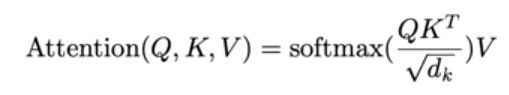

In [ ]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [ ]:
k.var()

tensor(1.0449)

In [ ]:
q.var()

tensor(1.0700)

In [ ]:
wei.var()

tensor(1.0918)

In [ ]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [ ]:
# without the scaled 1/sqrt(head_size), the resulting softmax converges to highest values
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

In [ ]:
class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [ ]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs

(tensor(0.1469), tensor(0.8803))

In [ ]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

(tensor(-9.5367e-09), tensor(1.0000))

In [ ]:
# French to English translation example:

# <--------- ENCODE ------------------><--------------- DECODE ----------------->
# les réseaux de neurones sont géniaux! <START> neural networks are awesome!<END>



## Full finished code

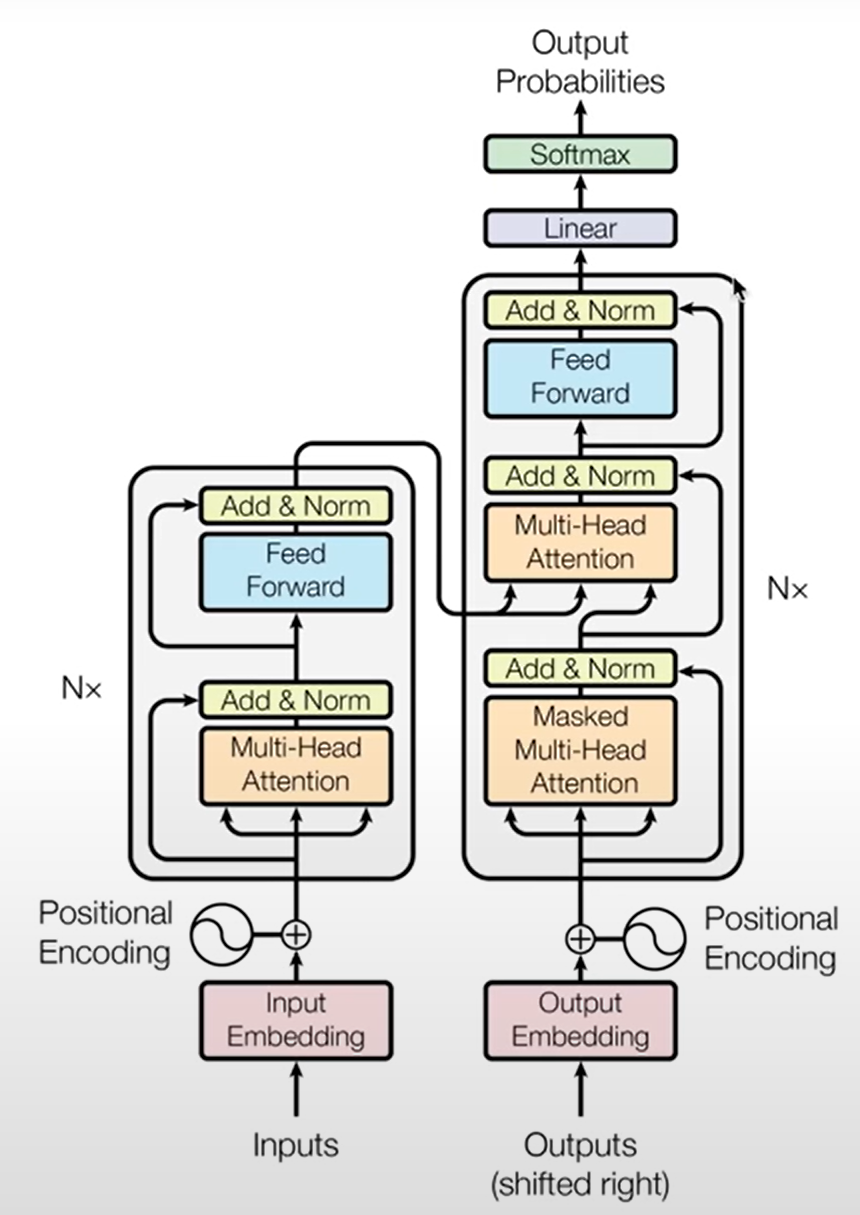

Class Block is Nx in this diagram  

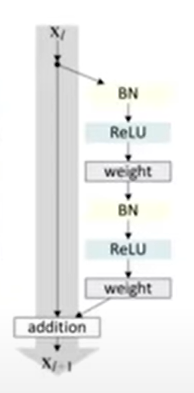

**Problem**: Deep neural nets suffer from optimization issues

**Solution 1**: residual nets


The "skip" arrows from add&norm to add&norm are residual connections.

Basically, the computation occurs top to bottom, and there is a residual pathway (gray), and you are free to fork off from the residual pathway, perform some computation, and project back to the residual pathway via addition. So we go from the inputs to the targets via plus, plus, plus...

Why addition?

During backpropagation, addition distributes gradients equally to both branches that feed the input. So the gradients from the loss, hop through every addition node all the way to the input and then also fork off into the residual blocks (the BN -> ReLU -> weight branch on the right).

Residual connections are "gradient superhighway" that goes directly from supervision all the way to input uninterrupted. The residual blocks are usually initialized in the beginning so they contribute little/nothing to the residual pathway. In the beginning the residual blocks are not there (because of how they are initialized), but during optimizaiton they come "online" and start to contribute

**Solution 2**: LayerNorm

LayerNorm is very simialr to BatchNorm. Batch normalization makes sure that across the batch dimension, any neuron had unit Gaussian distribution (0 mean and 1 sd) output. BatchNorm normalizes every column of input (and row is not normalized). LayerNorm is the exact same, except it normalizes every row (and column is not normalized)

### Pre-norm Formulation (slight deviation from original paper)

In practice, pre-norm formulation is better and more commonly used. Basically, the add&norm block occurs before the transformation, not after. The following code uses pre-norm formulation

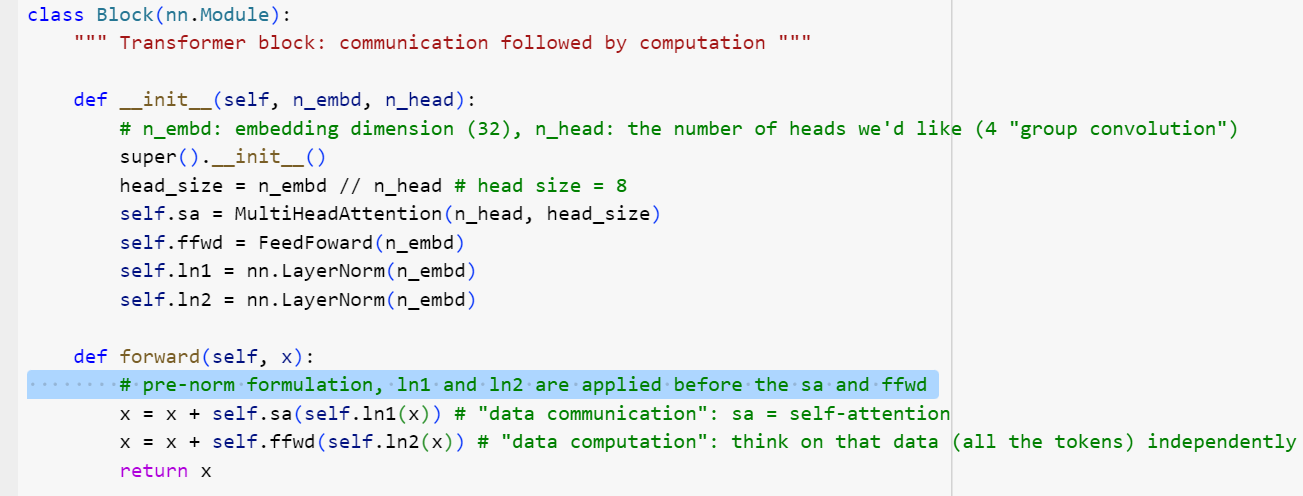

## Dropout layer

Every forward/backward pass, shuts off some random subset of neurons (drops them to zero) and trains without them. Effectively, because the neurons are being dropped off randomly for every forward and backward pass, the net ends up training an ensemble of sub-networks. At test time, everything is fully enabled and all of those subnetworks are merged into a single ensemble (remember that ensemble methods are "free" ways to improve accuracy).

In essence, dropout layer is a regularization technique which is often used when scaling up a model and we want to fight overfitting.

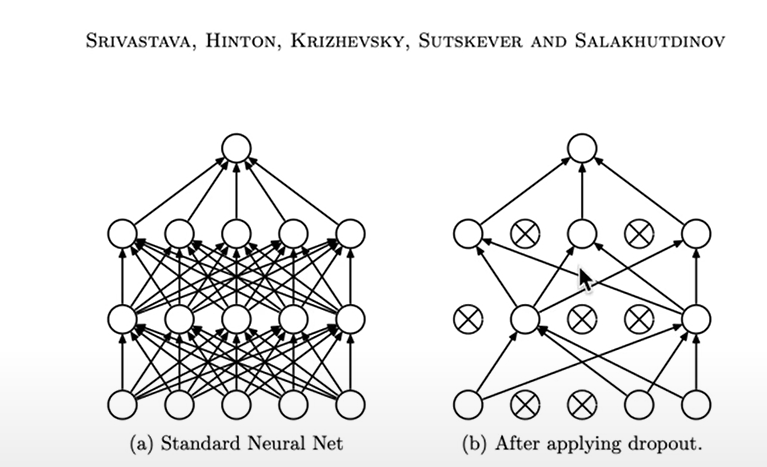

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
context_length = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_length, (batch_size,))
    x = torch.stack([data[i:i+context_length] for i in ix])
    y = torch.stack([data[i+1:i+context_length+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# averages loss over multiple losses to have a smoother and less noisy loss over time
@torch.no_grad() # tell pytorch we have no intetion to do backprop so torch can be more memory efficient when running this fxn
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(context_length, context_length))) # add a persistent buffer to the nn.module. This buffer (self.tril) will not be updated during backpropagation when you are training your model

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)]) # multiple heads in parallel
        self.proj = nn.Linear(n_embd, n_embd) # residual connection
        self.dropout = nn.Dropout(dropout)

    def forward(self, x): # run heads in parallel and concatenate them together in the channel dimension
        out = torch.cat([h(x) for h in self.heads], dim=-1) # output of self-attention
        out = self.dropout(self.proj(out)) # apply projection (projection back into residual pathway). Projection is just a linear transformation of the output of self-attention
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd), # inner-layer has multiplier of 4 for more neurons that does computing (just performed best empirically according to "attention is all you need" paper)
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # projection layer going back into residual pathway
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension (32), n_head: the number of heads we'd like (4 "group convolution")
        super().__init__()
        head_size = n_embd // n_head # head size = 8
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        # pre-norm formulation, ln1 and ln2 are applied before the sa and ffwd
        x = x + self.sa(self.ln1(x)) # "data communication": sa = self-attention
        x = x + self.ffwd(self.ln2(x)) # "data computation": think on that data (all the tokens) independently
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # n_embed=32 dimensional embedding
        self.position_embedding_table = nn.Embedding(context_length, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)]) # n_layer amount of blocks
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            # inference mode
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last context_length tokens (because positional emedding is only size context_length)
            idx_cond = idx[:, -context_length:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.209729 M parameters
step 0: train loss 4.4116, val loss 4.4022
step 100: train loss 2.6568, val loss 2.6670
step 200: train loss 2.5090, val loss 2.5058
step 300: train loss 2.4198, val loss 2.4340
step 400: train loss 2.3503, val loss 2.3567
step 500: train loss 2.2970, val loss 2.3136
step 600: train loss 2.2410, val loss 2.2506
step 700: train loss 2.2062, val loss 2.2198
step 800: train loss 2.1638, val loss 2.1871
step 900: train loss 2.1232, val loss 2.1494
step 1000: train loss 2.1020, val loss 2.1293
step 1100: train loss 2.0704, val loss 2.1196
step 1200: train loss 2.0382, val loss 2.0798
step 1300: train loss 2.0249, val loss 2.0640
step 1400: train loss 1.9922, val loss 2.0354
step 1500: train loss 1.9707, val loss 2.0308
step 1600: train loss 1.9614, val loss 2.0474
step 1700: train loss 1.9393, val loss 2.0130
step 1800: train loss 1.9070, val loss 1.9943
step 1900: train loss 1.9057, val loss 1.9871
step 2000: train loss 1.8834, val loss 1.9954
step 2100: train loss 1.

## Scaled up NanoGPT

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
context_length = 256 # 256 characters of context (to predict 257th)
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4 # brought down LR since NN is bigger
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6 # every head is 384/6 = 64 dimensional
n_layer = 6
dropout = 0.2
# ------------

torch.manual_seed(1337)

# ! wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_length, (batch_size,))
    x = torch.stack([data[i:i+context_length] for i in ix])
    y = torch.stack([data[i+1:i+context_length+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# averages loss over multiple losses to have a smoother and less noisy loss over time
@torch.no_grad() # tell pytorch we have no intetion to do backprop so torch can be more memory efficient when running this fxn
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(context_length, context_length))) # add a persistent buffer to the nn.module. This buffer (self.tril) will not be updated during backpropagation when you are training your model

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)]) # multiple heads in parallel
        self.proj = nn.Linear(n_embd, n_embd) # residual connection
        self.dropout = nn.Dropout(dropout)

    def forward(self, x): # run heads in parallel and concatenate them together in the channel dimension
        out = torch.cat([h(x) for h in self.heads], dim=-1) # output of self-attention
        out = self.dropout(self.proj(out)) # apply projection (projection back into residual pathway). Projection is just a linear transformation of the output of self-attention
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd), # inner-layer has multiplier of 4 for more neurons that does computing (just performed best empirically according to "attention is all you need" paper)
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # projection layer going back into residual pathway
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension (32)
        # n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head # head size = 8
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        # pre-norm formulation, ln1 and ln2 are applied before the sa and ffwd
        x = x + self.sa(self.ln1(x)) # "data communication": sa = self-attention
        x = x + self.ffwd(self.ln2(x)) # "data computation": think on that data (all the tokens) independently
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # n_embed=32 dimensional embedding
        self.position_embedding_table = nn.Embedding(context_length, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)]) # n_layer amount of blocks
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            # inference mode
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last context_length tokens (because positional emedding is only size context_length)
            idx_cond = idx[:, -context_length:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


--2024-03-10 21:51:12--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2024-03-10 21:51:13 (40.0 MB/s) - ‘input.txt’ saved [1115394/1115394]

10.788929 M parameters
step 0: train loss 4.2849, val loss 4.2823
step 500: train loss 1.9703, val loss 2.0866
step 1000: train loss 1.5154, val loss 1.7258
step 1500: train loss 1.3800, val loss 1.6035
step 2000: train loss 1.2776, val loss 1.5499
step 2500: train loss 1.2050, val loss 1.5212
step 3000: train loss 1.1403, val loss 1.5140
step 3500: train loss 1.0849, val loss 1.5151
step 4000: tra